# Event Study (Dynamic DiD) with `pymc` models

This notebook demonstrates how to use CausalPy's `EventStudy` class to estimate **dynamic treatment effects** over event time. This is also known as a "dynamic {term}`difference in differences`" analysis.

:::{note}
{term}`Event study` is a powerful tool for:
1. Examining **pre-treatment trends** (placebo checks for {term}`parallel trends assumption`)
2. Estimating how **treatment effects evolve over time** after treatment
3. Visualizing the full **time path of causal effects**
:::

## Background: What is an Event Study?

An event study analyzes panel data where some units receive treatment at a specific time. Unlike standard difference-in-differences which estimates a single average treatment effect, event studies estimate **separate coefficients for each time period relative to treatment**.

The key concept is **event time** (or relative time):
$$E_{it} = t - G_i$$

where $t$ is the calendar time and $G_i$ is the treatment time for unit $i$.

The model estimates:
$$Y_{it} = \alpha_i + \lambda_t + \sum_{k \neq k_0} \beta_k \cdot \mathbf{1}\{E_{it} = k\} + \varepsilon_{it}$$

where:
- $\alpha_i$ are unit fixed effects
- $\lambda_t$ are time fixed effects
- $\beta_k$ are the dynamic treatment effects at event time $k$
- $k_0$ is the reference (omitted) period, typically $k=-1$

**Interpretation:**
- $\beta_k$ for $k < 0$ (pre-treatment): Should be near zero if parallel trends hold
- $\beta_k$ for $k \geq 0$ (post-treatment): Measure the causal effect at each period after treatment


In [1]:
import arviz as az
import matplotlib.pyplot as plt

import causalpy as cp
from causalpy.data.simulate_data import generate_event_study_data

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## Generate Simulated Data

We'll create synthetic panel data with:
- 30 units (half treated, half control)
- 20 time periods
- Treatment occurring at time 10
- Known treatment effects: zero pre-treatment, gradually increasing post-treatment


In [3]:
# Define known treatment effects for simulation
# Pre-treatment: no effect (parallel trends)
# Post-treatment: effect increases over time
true_effects = {
    -5: 0.0,
    -4: 0.0,
    -3: 0.0,
    -2: 0.0,
    -1: 0.0,  # Pre-treatment
    0: 0.5,
    1: 0.7,
    2: 0.9,
    3: 1.0,
    4: 1.0,
    5: 1.0,  # Post-treatment
}

df = generate_event_study_data(
    n_units=30,
    n_time=20,
    treatment_time=10,
    treated_fraction=0.5,
    event_window=(-5, 5),
    treatment_effects=true_effects,
    unit_fe_sigma=1.0,
    time_fe_sigma=0.3,
    noise_sigma=0.2,
    seed=seed,
)

print(f"Data shape: {df.shape}")
df.head(10)

Data shape: (600, 5)


,unit,time,y,treat_time,treated
0,0,0,0.381019,10.0,1
1,0,1,0.975381,10.0,1
2,0,2,0.357281,10.0,1
3,0,3,0.301736,10.0,1
4,0,4,0.949678,10.0,1
5,0,5,0.316717,10.0,1
6,0,6,0.391530,10.0,1
7,0,7,-0.153029,10.0,1
8,0,8,0.164511,10.0,1
9,0,9,0.750882,10.0,1


Let's visualize the data to understand its structure:


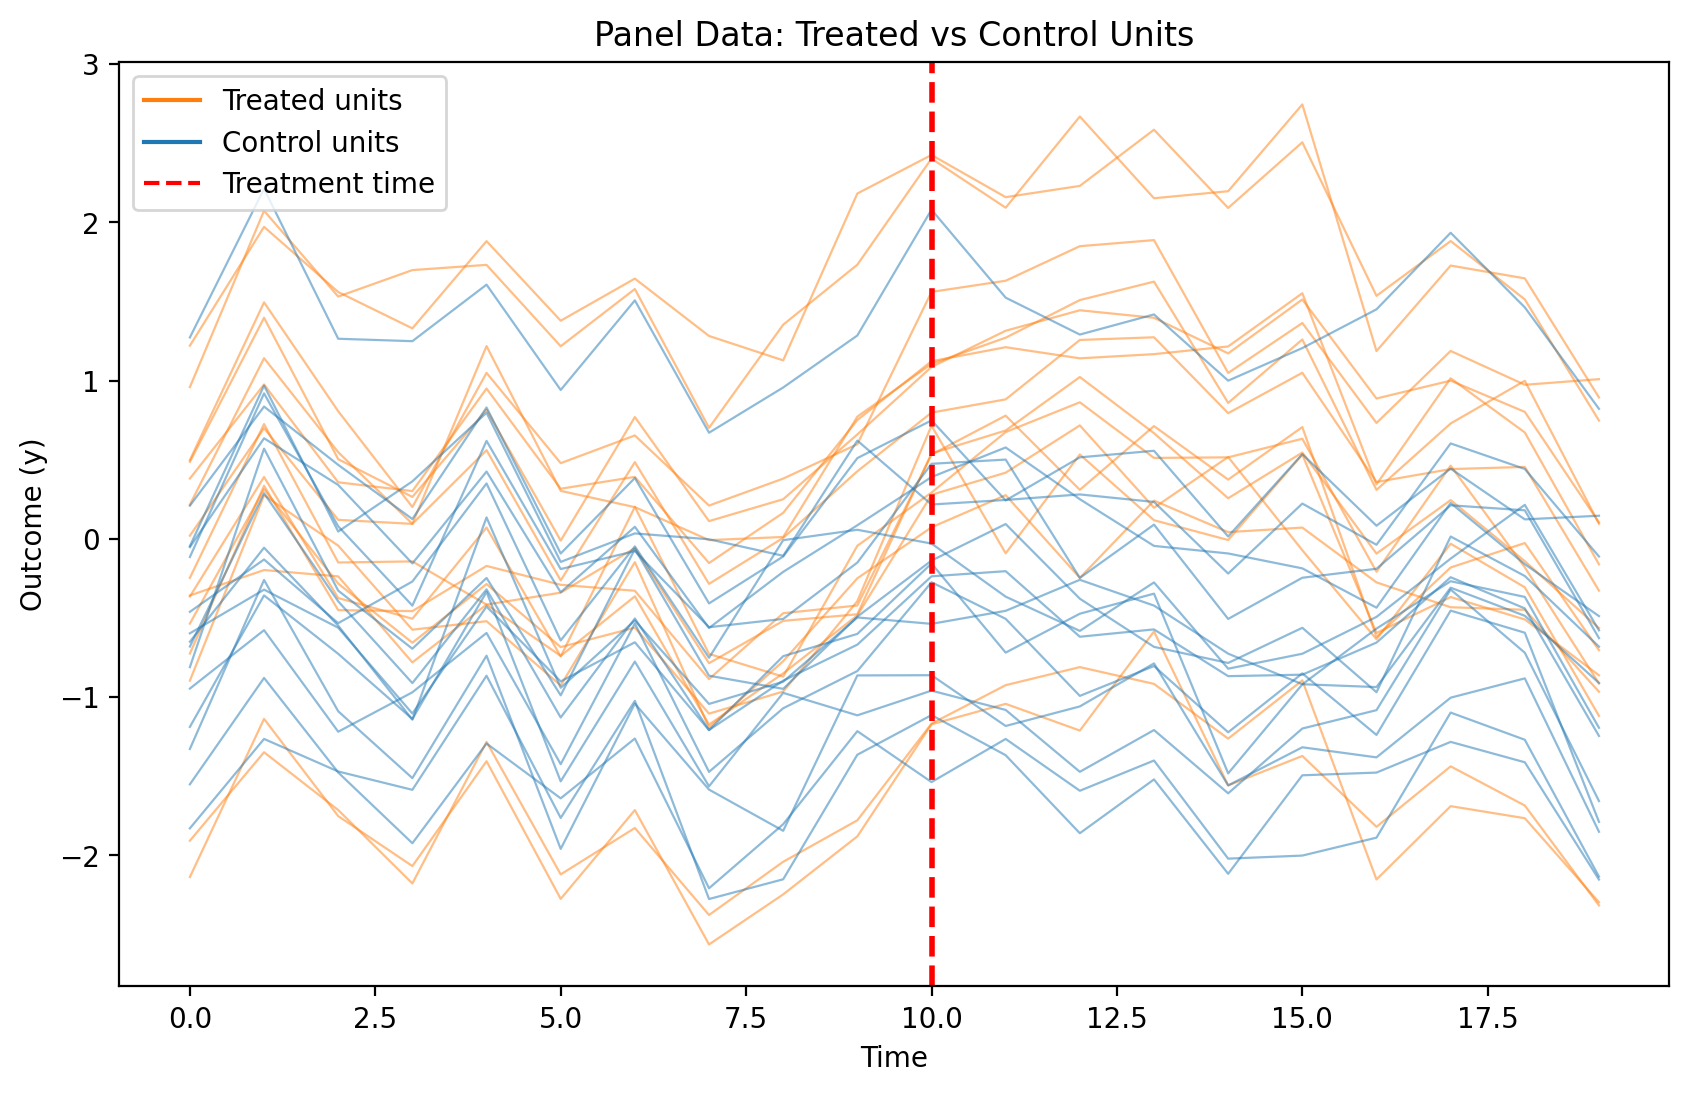

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each unit's time series
for unit in df["unit"].unique():
    unit_data = df[df["unit"] == unit]
    is_treated = unit_data["treated"].iloc[0] == 1
    color = "C1" if is_treated else "C0"
    alpha = 0.5
    ax.plot(unit_data["time"], unit_data["y"], color=color, alpha=alpha, linewidth=0.8)

# Add vertical line at treatment time
ax.axvline(x=10, color="red", linestyle="--", linewidth=2, label="Treatment time")

# Legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color="C1", label="Treated units"),
    Line2D([0], [0], color="C0", label="Control units"),
    Line2D([0], [0], color="red", linestyle="--", label="Treatment time"),
]
ax.legend(handles=legend_elements, loc="upper left")

ax.set_xlabel("Time")
ax.set_ylabel("Outcome (y)")
ax.set_title("Panel Data: Treated vs Control Units")
plt.show()

## Run the Event Study Analysis

Now we use CausalPy's `EventStudy` class to estimate the dynamic treatment effects.

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::


In [5]:
result = cp.EventStudy(
    df,
    unit_col="unit",
    time_col="time",
    outcome_col="y",
    treat_time_col="treat_time",
    event_window=(-5, 5),
    reference_event_time=-1,  # One period before treatment as reference
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]


## Visualize the Results

The event study plot shows the estimated treatment effects ($\beta_k$) at each event time, with credible intervals. This is the key diagnostic plot for event studies.


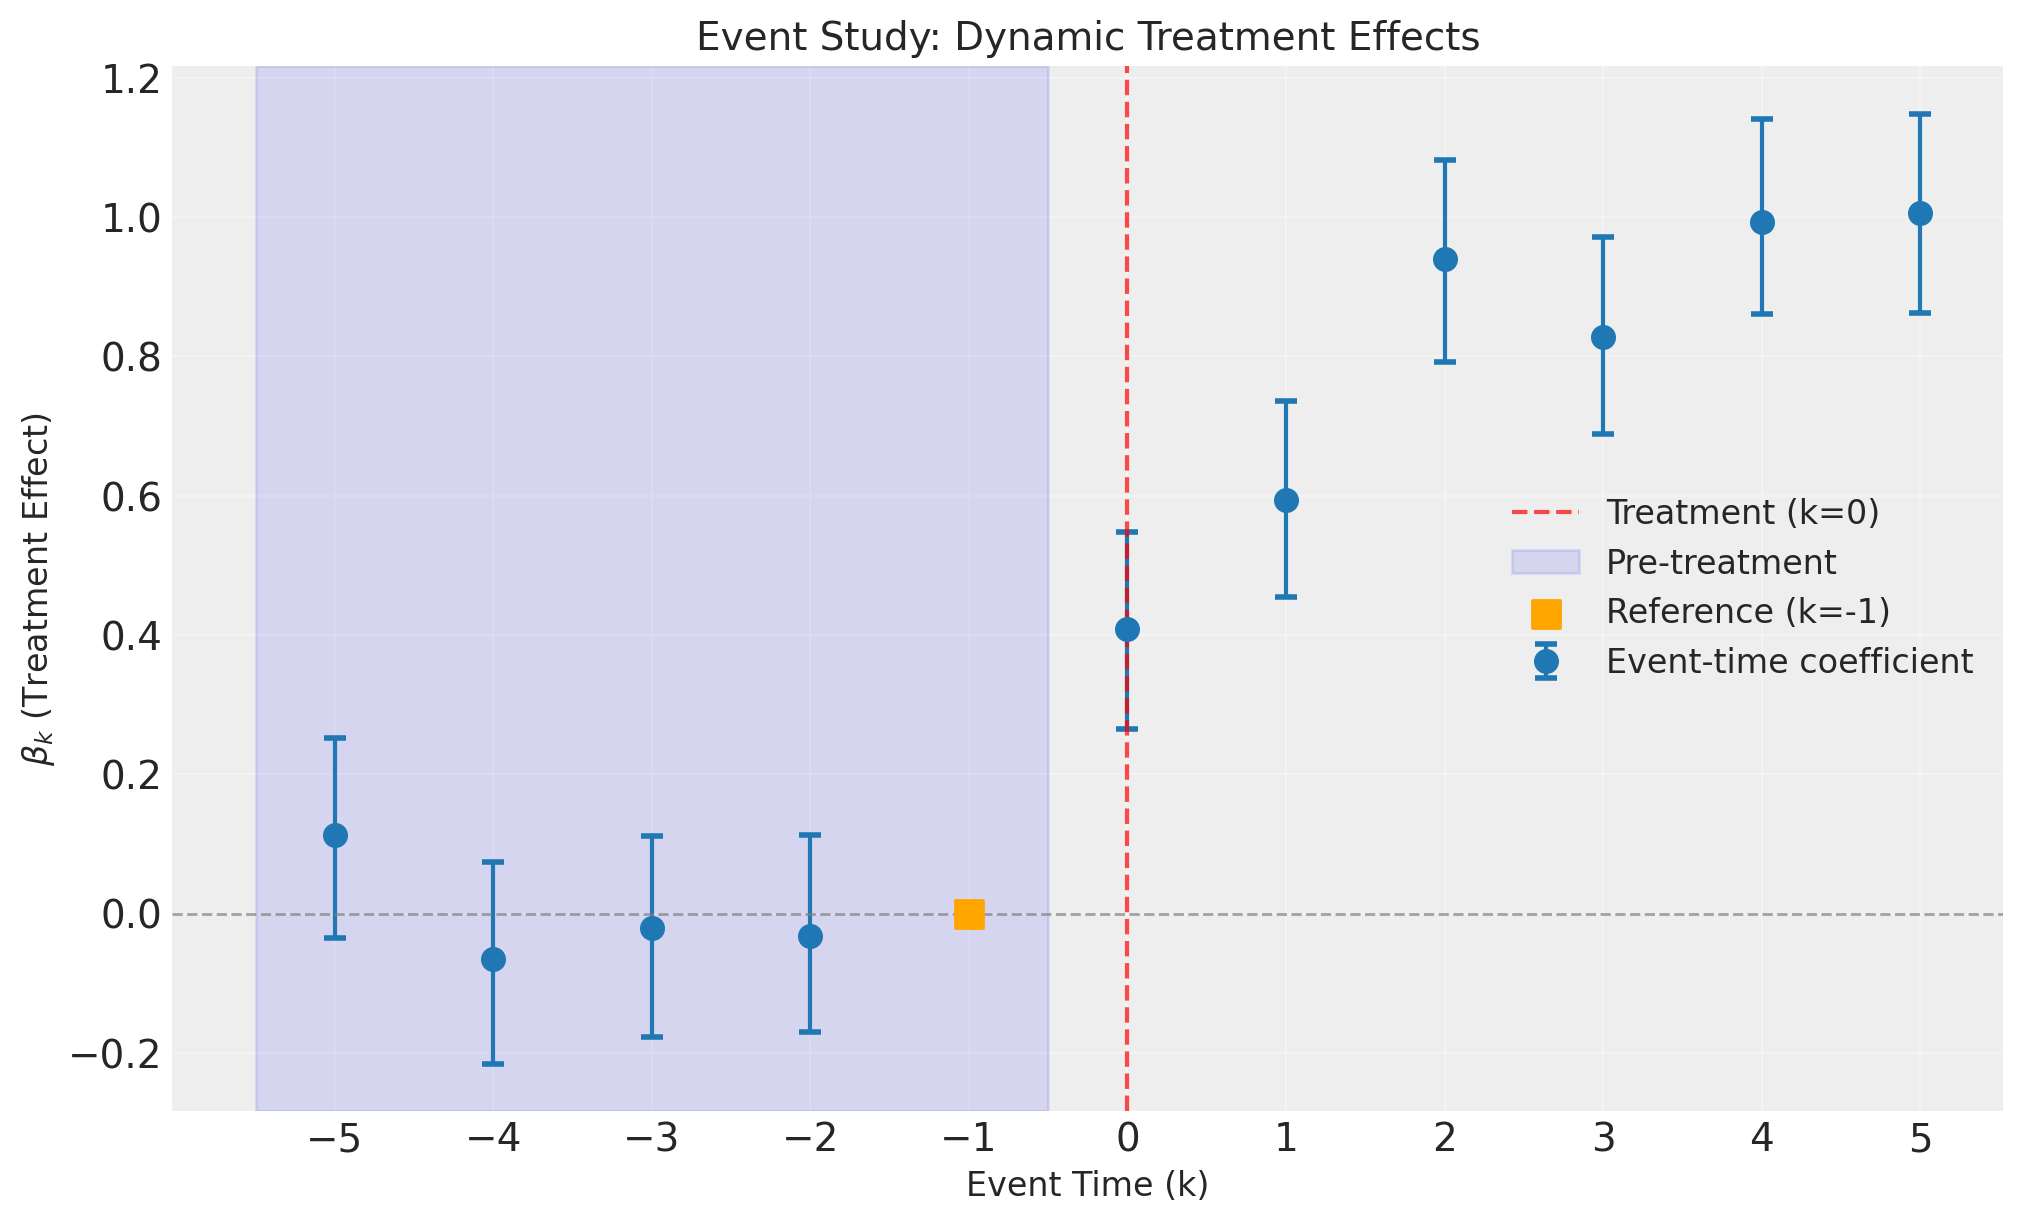

In [6]:
fig, ax = result.plot()

**Interpreting the Plot:**

1. **Pre-treatment periods** ($k < 0$, blue shaded): The coefficients should be close to zero. This is a key test of the parallel trends assumption. If we see significant pre-trends, our causal estimates may be biased.

2. **Reference period** ($k = -1$, orange square): This is fixed at zero by construction. All other coefficients are interpreted relative to this period.

3. **Post-treatment periods** ($k \geq 0$): These show how the treatment effect evolves over time. In our simulated data, we see the effect starts at about 0.5 and increases to around 1.0.

4. **Credible intervals**: The error bars show 94% highest density intervals. When these don't include zero for post-treatment periods, we have strong evidence of a treatment effect.


## Summary Statistics


In [7]:
result.summary()

==================================Event Study===================================
Event window: (-5, 5)
Reference event time: -1

Event-time coefficients (beta_k):
------------------------------------------------------------
  Event Time       Mean         SD     HDI 3%    HDI 97%
------------------------------------------------------------
          -5       0.11      0.077     -0.035       0.25
          -4     -0.065      0.077      -0.22      0.073
          -3     -0.021      0.078      -0.18       0.11
          -2     -0.032      0.075      -0.17       0.11
          -1    0 (ref)          -          -          -
           0       0.41      0.076       0.26       0.55
           1       0.59      0.075       0.45       0.74
           2       0.94      0.078       0.79        1.1
           3       0.83      0.075       0.69       0.97
           4       0.99      0.075       0.86        1.1
           5          1      0.076       0.86        1.1
-------------------------------

We can also get the event-time coefficients as a DataFrame for further analysis:


In [8]:
summary_df = result.get_event_time_summary()
summary_df

,event_time,mean,std,hdi_3%,hdi_97%,is_reference
0,-5,0.113427,0.076994,-0.035227,0.251823,False
1,-4,-0.064592,0.076905,-0.215547,0.073316,False
2,-3,-0.021091,0.077551,-0.177766,0.111183,False
3,-2,-0.032195,0.074954,-0.169954,0.112547,False
4,-1,0.000000,0.000000,0.000000,0.000000,True
5,0,0.409094,0.075700,0.264636,0.548505,False
6,1,0.593974,0.075284,0.454389,0.735734,False
7,2,0.940384,0.077661,0.792238,1.081568,False
8,3,0.827706,0.075419,0.688432,0.971350,False
9,4,0.992739,0.075394,0.860349,1.140122,False


## Compare Estimated vs True Effects

Since we simulated the data with known treatment effects, we can compare our estimates to the true values:


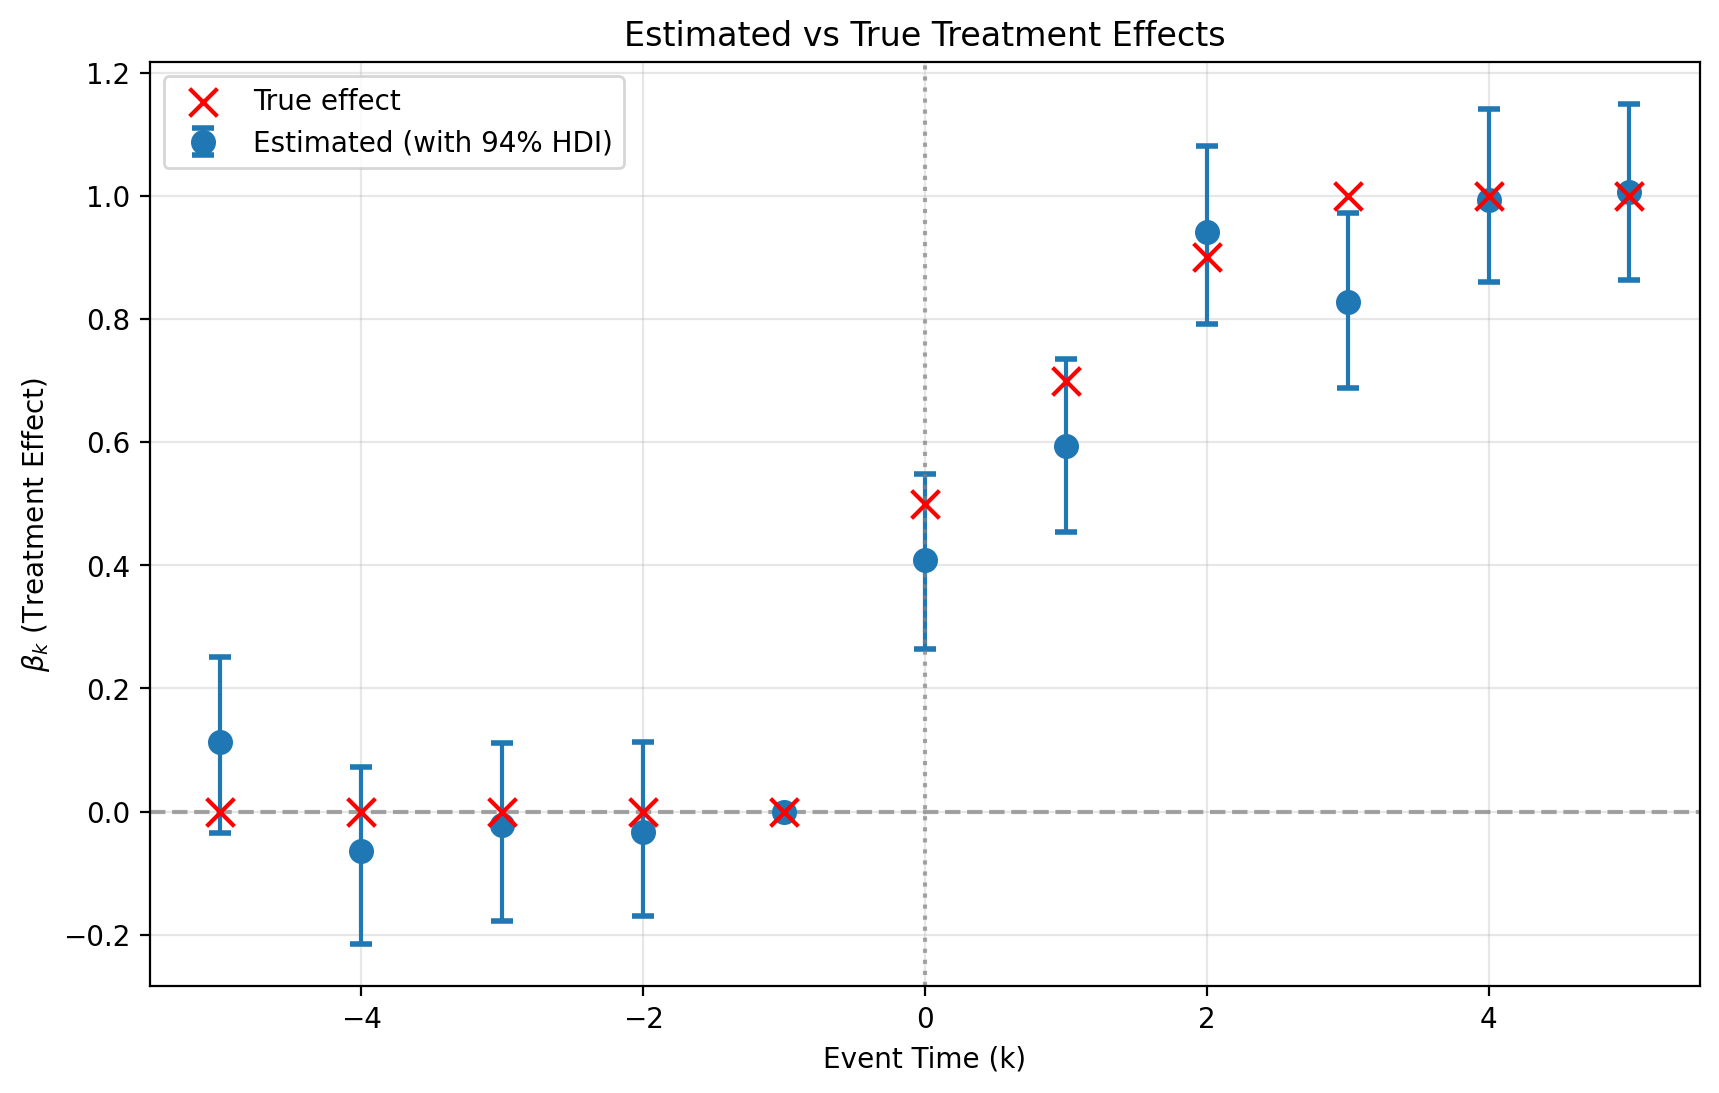

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot estimated effects
event_times = summary_df["event_time"].values
estimated_means = summary_df["mean"].values
lower = summary_df["hdi_3%"].values
upper = summary_df["hdi_97%"].values

ax.errorbar(
    event_times,
    estimated_means,
    yerr=[estimated_means - lower, upper - estimated_means],
    fmt="o",
    capsize=4,
    capthick=2,
    markersize=8,
    color="C0",
    label="Estimated (with 94% HDI)",
)

# Plot true effects (relative to k=-1 reference)
# Since k=-1 is our reference, we need to subtract true_effects[-1] from all
true_effects_relative = {k: v - true_effects[-1] for k, v in true_effects.items()}
true_k = list(true_effects_relative.keys())
true_beta = list(true_effects_relative.values())
ax.scatter(
    true_k, true_beta, marker="x", s=100, color="red", zorder=5, label="True effect"
)

ax.axhline(y=0, color="gray", linestyle="--", alpha=0.7)
ax.axvline(x=0, color="gray", linestyle=":", alpha=0.7)
ax.set_xlabel("Event Time (k)")
ax.set_ylabel(r"$\beta_k$ (Treatment Effect)")
ax.set_title("Estimated vs True Treatment Effects")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

The estimated effects closely track the true effects, demonstrating that the event study correctly recovers the dynamic treatment effects.


## Pre-Trend Analysis

A key assumption in event studies is **parallel trends**: without treatment, treated and control units would have followed similar outcome trajectories. We can assess this by examining the pre-treatment coefficients.

If parallel trends hold, pre-treatment coefficients ($\beta_k$ for $k < 0$) should be close to zero:


In [10]:
# Extract pre-treatment coefficients
pre_treatment = summary_df[summary_df["event_time"] < 0]
pre_treatment = pre_treatment[~pre_treatment["is_reference"]]

print("Pre-treatment coefficient estimates:")
print(pre_treatment[["event_time", "mean", "hdi_3%", "hdi_97%"]].to_string(index=False))

# Check if 94% HDIs include zero
pre_includes_zero = (
    (pre_treatment["hdi_3%"] <= 0) & (pre_treatment["hdi_97%"] >= 0)
).all()
print(f"\nAll pre-treatment 94% HDIs include zero: {pre_includes_zero}")

Pre-treatment coefficient estimates:
 event_time      mean    hdi_3%  hdi_97%
         -5  0.113427 -0.035227 0.251823
         -4 -0.064592 -0.215547 0.073316
         -3 -0.021091 -0.177766 0.111183
         -2 -0.032195 -0.169954 0.112547

All pre-treatment 94% HDIs include zero: True


Since all pre-treatment coefficient credible intervals include zero, we have no evidence against the parallel trends assumption. This gives us confidence in our post-treatment causal estimates.


## Posterior Analysis

We can use ArviZ to examine the posterior distributions of specific event-time coefficients:


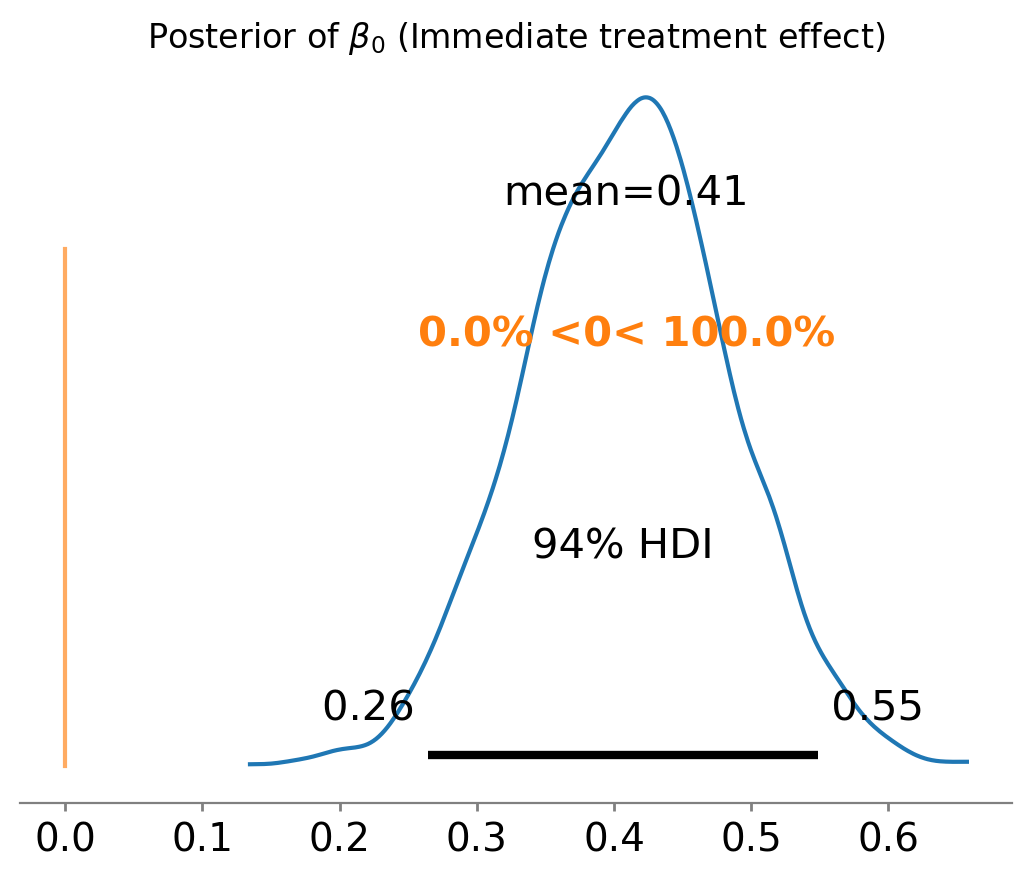

In [11]:
# Plot posterior for event time k=0 (immediate treatment effect)
if 0 in result.event_time_coeffs and hasattr(result.event_time_coeffs[0], "values"):
    ax = az.plot_posterior(result.event_time_coeffs[0].values.flatten(), ref_val=0)
    ax.set_title(r"Posterior of $\beta_0$ (Immediate treatment effect)")

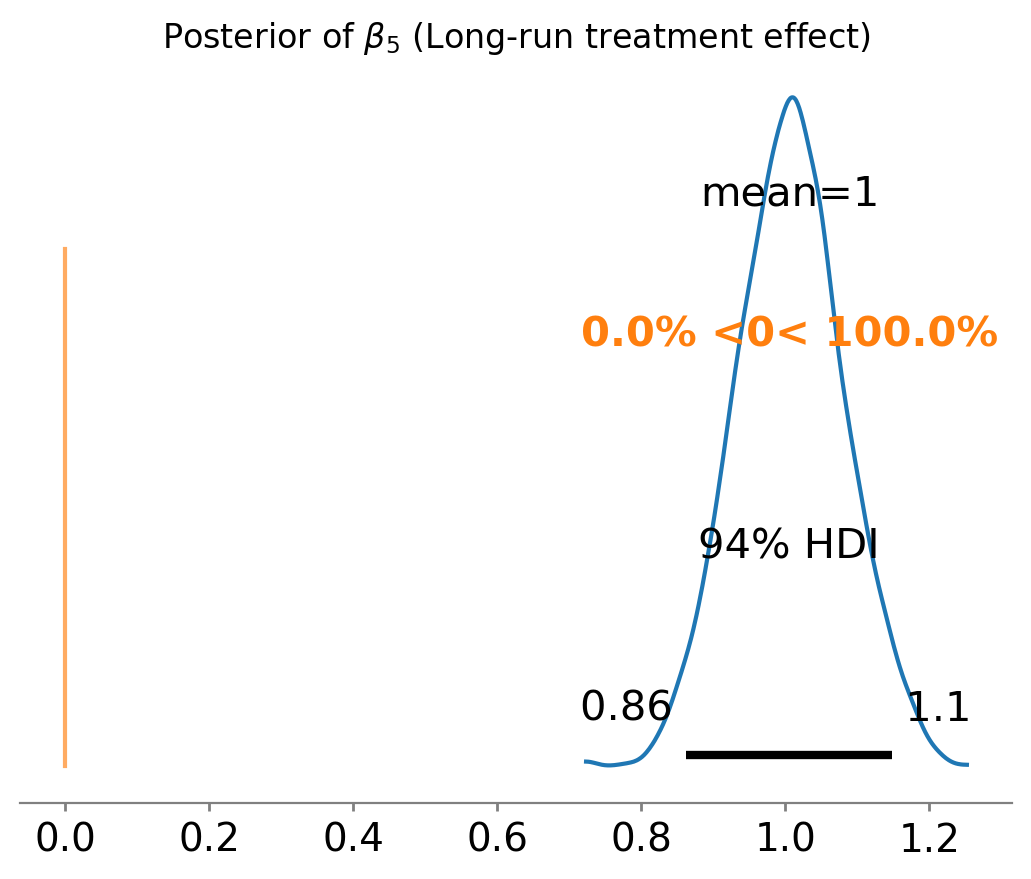

In [12]:
# Plot posterior for event time k=5 (long-run treatment effect)
if 5 in result.event_time_coeffs and hasattr(result.event_time_coeffs[5], "values"):
    ax = az.plot_posterior(result.event_time_coeffs[5].values.flatten(), ref_val=0)
    ax.set_title(r"Posterior of $\beta_5$ (Long-run treatment effect)")

## Key Takeaways

1. **Event studies** provide richer information than standard DiD by estimating treatment effects at each event time.

2. **Pre-trend analysis** is crucial: coefficients for $k < 0$ should be near zero to support the parallel trends assumption.

3. **Dynamic effects** can reveal how treatment impacts evolve over time—whether effects are immediate, gradual, or temporary.

4. **The reference period** ($k_0$, typically -1) is normalized to zero. All coefficients are interpreted relative to this period.

5. **Bayesian estimation** provides full posterior distributions for each coefficient, enabling probabilistic statements about effect sizes.


## References

:::{bibliography}
:filter: docname in docnames
:::
